In [2]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [3]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [4]:
acc_healthy = pd.read_csv('data_new_preprocessed/acc_healthy_samples.csv')
acc_15 = pd.read_csv('data_new_preprocessed/acc_15_samples.csv')
acc_35 = pd.read_csv('data_new_preprocessed/acc_35_samples.csv')

gyro_healthy = pd.read_csv('data_new_preprocessed/gyro_healthy_samples.csv')
gyro_15 = pd.read_csv('data_new_preprocessed/gyro_15_samples.csv')
gyro_35 = pd.read_csv('data_new_preprocessed/gyro_35_samples.csv')

gyro_agg_healthy = pd.read_csv('data_new_preprocessed/gyro_agg_healthy_samples.csv')
gyro_agg_15 = pd.read_csv('data_new_preprocessed/gyro_agg_15_samples.csv')
gyro_agg_35 = pd.read_csv('data_new_preprocessed/gyro_agg_35_samples.csv')

In [5]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_15_data = np.array([acc_15[col].values for col in acc_15.columns if col.startswith('Sample')])
acc_35_data = np.array([acc_35[col].values for col in acc_35.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_15_data,acc_35_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_15_data = np.array([gyro_15[col].values for col in gyro_15.columns if col.startswith('Sample')])
gyro_35_data = np.array([gyro_35[col].values for col in gyro_35.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_15_data,gyro_35_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_15_data = np.array([gyro_agg_15[col].values for col in gyro_agg_15.columns if col.startswith('Sample')])
gyro_agg_35_data = np.array([gyro_agg_35[col].values for col in gyro_agg_35.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_15_data, gyro_agg_35_data]

In [213]:
len(acc[0]) +len(acc[1]) + len(acc[2])

158

In [216]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, 
                 mode = 'binary', training_samples = [10,10],lambda0=None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        IL1 = training_samples[0]
        IL2 = training_samples[1]
        IL = IL1+IL2

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])+len(data_array[2])
        data_array_damaged = np.concatenate([data_array[1], data_array[2]])
        total = num_healthy + num_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array_damaged)[sampling_order_2[:IL2]]])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array_damaged)[sampling_order_2[IL2:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

        IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        IL1 = training_samples[0]
        IL2 = training_samples[1]
        IL3 = training_samples[2]
        IL = IL1+IL2+IL3

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])
        num_very_damaged = len(data_array[2])

        total = num_healthy + num_damaged + num_very_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])
        sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array[1])[sampling_order_2[:IL2]],
            np.array(data_array[2])[sampling_order_3[:IL3]],
            ])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array[1])[sampling_order_2[IL2:]],
                np.array(data_array[2])[sampling_order_3[IL3:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

        IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out, y_test_labels, IT, IL, total, B0, knot_list,N
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary',plot = False, seed = None, N=None):
    if not seed:
        seed = np.random.randint(0,100000)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 3

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)

    if plot and mode == 'binary':
        fig, ax = plt.subplots(2,1,figsize=(12,8),tight_layout=True)

        x = np.arange(1,len(cat1p)+1)
        ax[0].scatter(x, (cat1p["mean"].values))
        ax[0].errorbar(x, cat1p["mean"].values, np.abs([cat1p["mean"].values-cat1p["hdi_3%"].values,
                    cat1p["hdi_97%"].values-cat1p["mean"].values]), linestyle='none')


        x = np.arange(1,len(cat2p)+1)
        ax[1].scatter(x, (cat2p["mean"].values))
        ax[1].errorbar(x, cat2p["mean"].values, np.abs([cat2p["mean"].values-cat2p["hdi_3%"].values,
                    cat2p["hdi_97%"].values-cat2p["mean"].values]), linestyle='none')



        ax[0].set_title('Healthy', loc='left',fontsize = 20)
        ax[0].set_ylabel('Probability',fontsize=16)
        ax[1].set_title('Damaged', loc='left',fontsize = 20)
        ax[1].set_ylabel('Probability',fontsize=16)
        ax[0].set_xticks([1,len(cat1p)])
        ax[1].set_xticks([1,len(cat2p)])
        ax[0].set_ylim([-0.05,1.05])
        ax[0].set_yticks([0,1])
        ax[1].set_ylim([-0.05,1.05])
        ax[1].set_yticks([0,1])
        ax[1].set_xlabel('Sample number',fontsize=16)
        fig.savefig('plots/ex_clas.jpg')

        # x = np.linspace(0,150,N)
        # fig = plt.figure(figsize=(12, 8), tight_layout = True)
        # axes = plt.subplot(1, 1 ,1)
        # y_pred= result.stan_variable('y_pred')[:,:]
        # axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
        # axes.set_xlabel('Time [ms]',fontsize = 15)
        # axes.set_ylabel('Amplitude',fontsize = 15)
        # axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
        # axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)
    # if plot and mode == 'all':
    if mode == 'binary':
        return result,[indices_cat1,indices_cat2]
    else:
        return result,[indices_cat1,indices_cat2,indices_cat3]
        

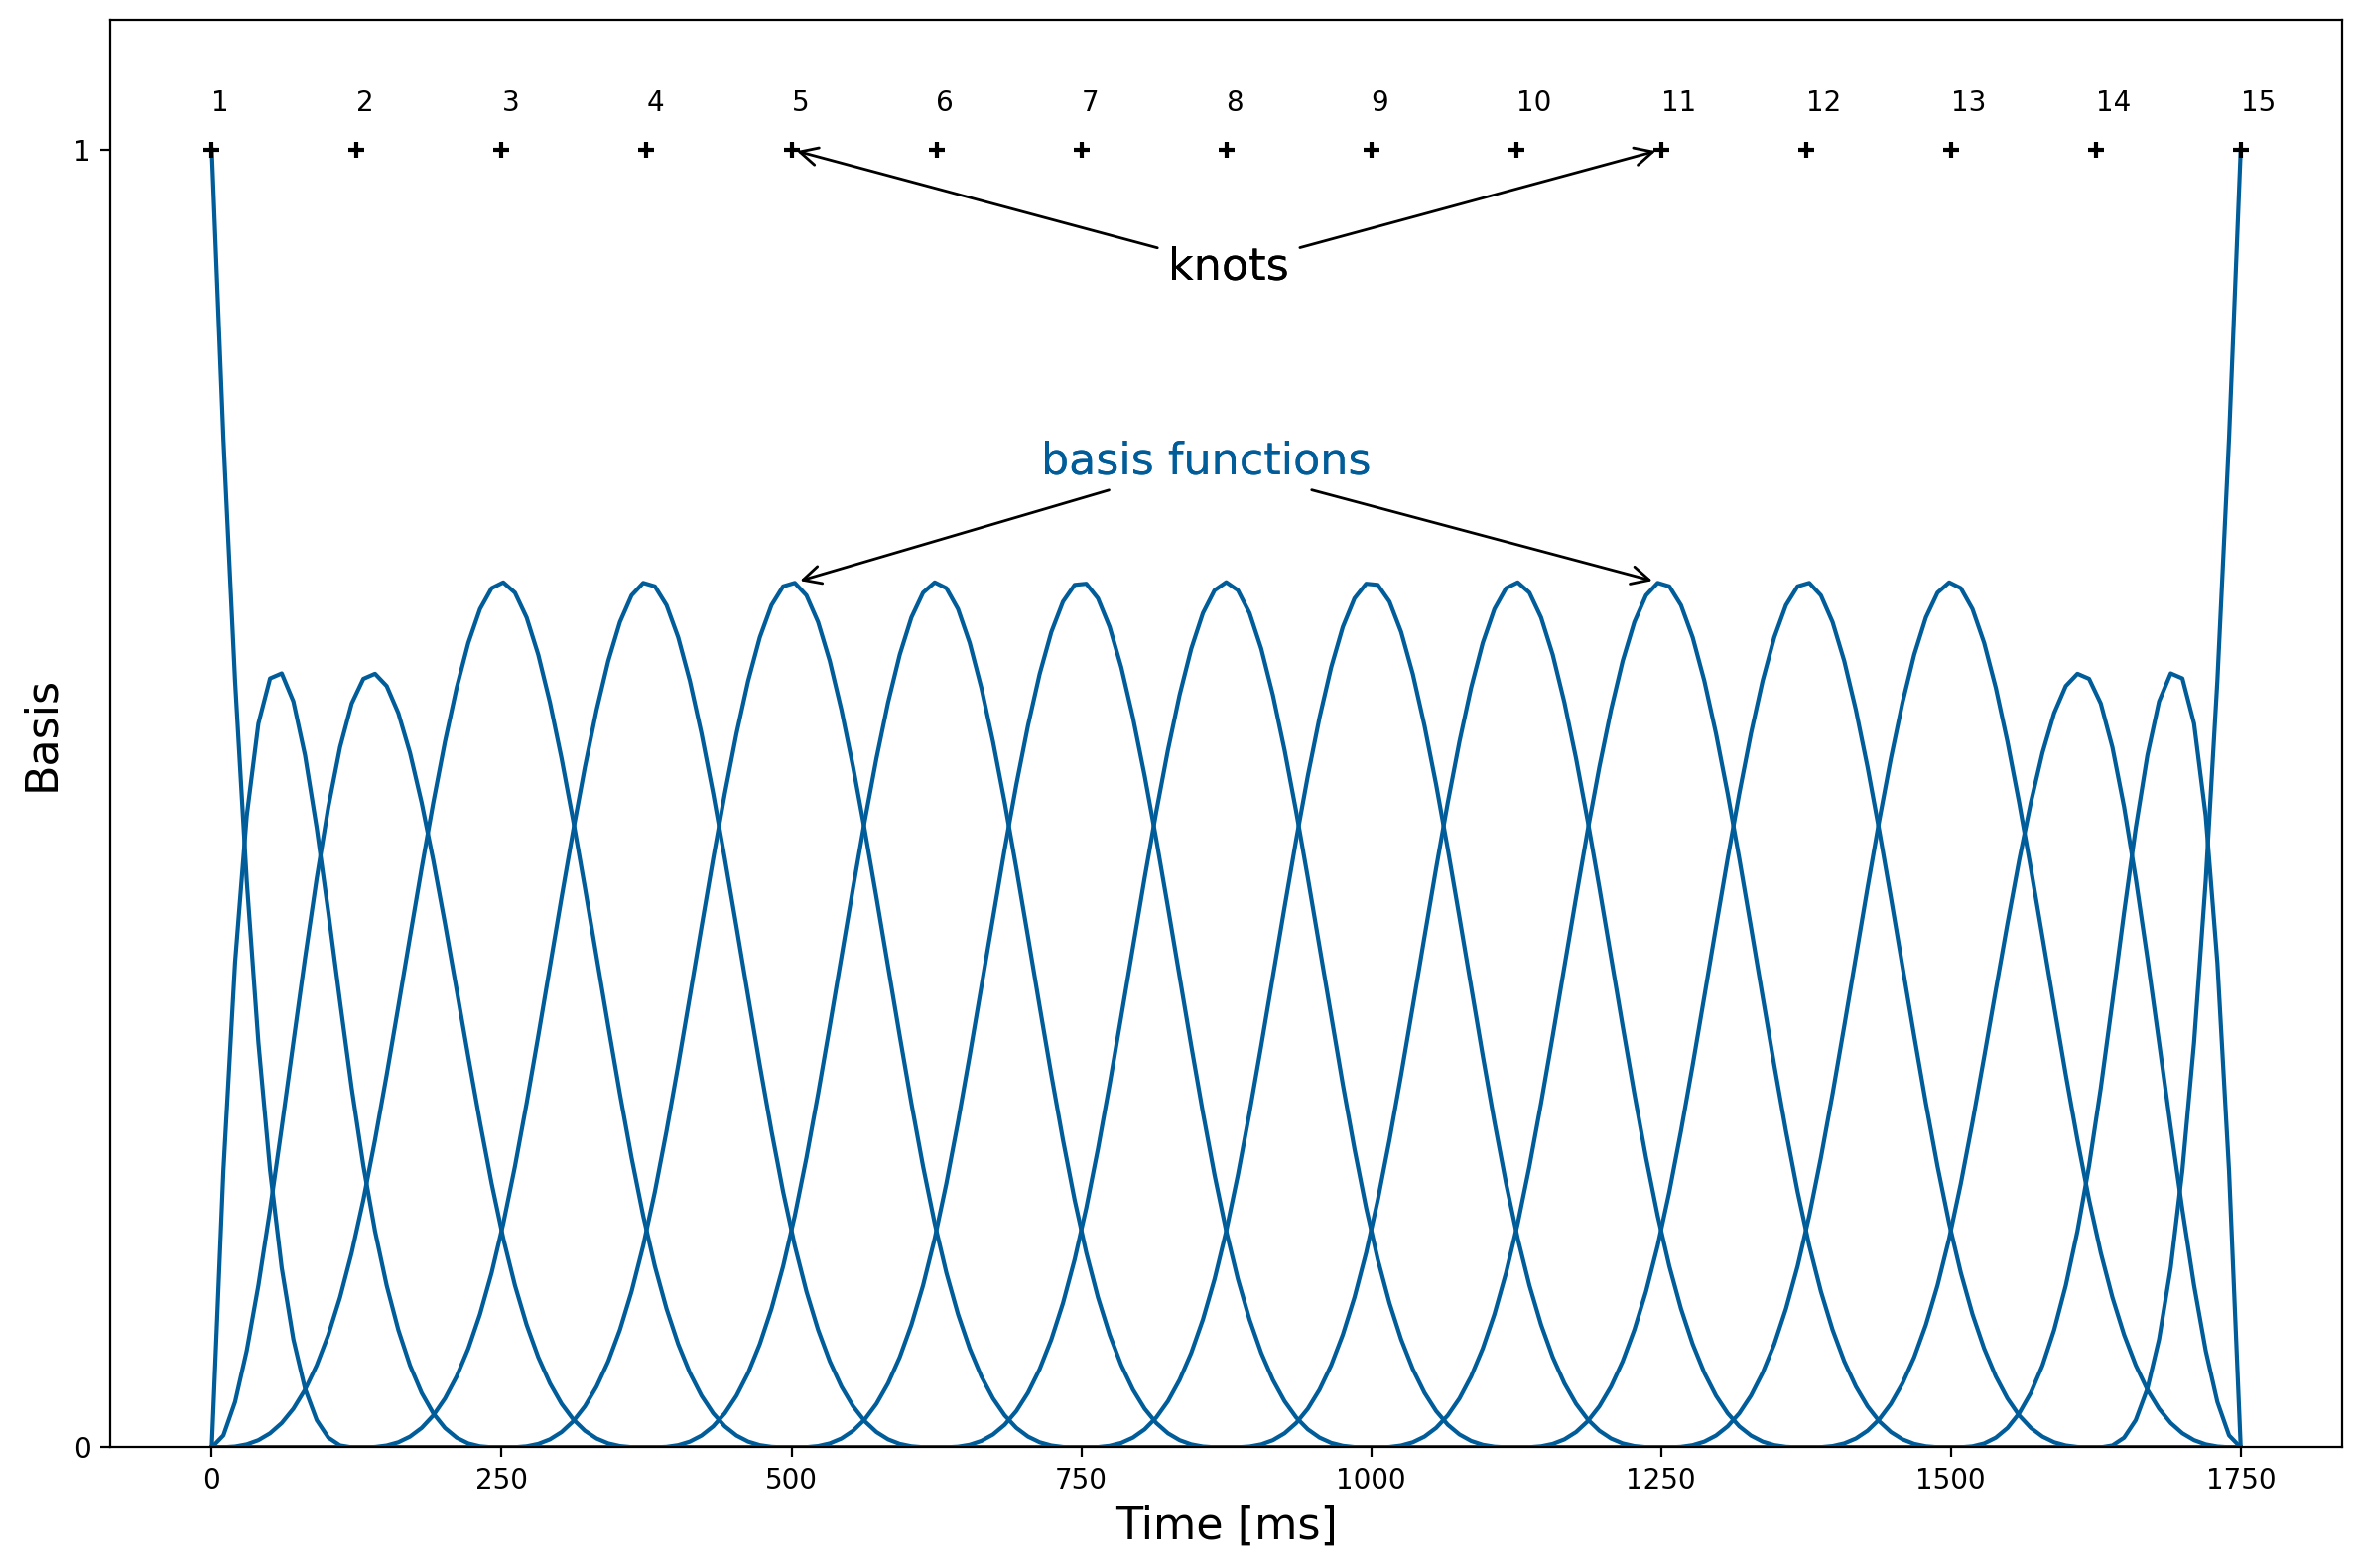

In [211]:
times = np.linspace(0,175*10,175)
knot_list = np.quantile(times,np.linspace(0,1,15))
B0 = create_spline_matrix(175, times, 3, 15)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
for i in range(15 + 2):
    ax.plot(times, (B0[:, i]), color=DARK, zorder=0)
    if i < 15:
        ax.text(s="{}".format(i + 1), x=knot_list[i] - 0.05, y=1.03)
        ax.scatter(knot_list[i], 1, marker="+", color="black", zorder=1)
ax.set_yticks([0, 1])
ax.set_ylim((0, 1.1))
ax.annotate(
    text="knots",
    xy=(knot_list[4], 1),
    xytext=(knot_list[6]+75, 0.9),
    arrowprops={"arrowstyle": "->"},fontsize=16
)
ax.annotate(
    text="knots",
    xy=(knot_list[10], 1),
    xytext=(knot_list[6]+75, 0.9),
    arrowprops={"arrowstyle": "->"},fontsize=16
)

ax.annotate(
    text="basis functions",
    xy=(times[np.argmax(B0[:, 5])], np.max(B0[:, 3])),
    xytext=(knot_list[5]+90, 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,fontsize=16
)
ax.annotate(
    text="basis functions",
    xy=(times[np.argmax(B0[:, 11])], np.max(B0[:, 8])),
    xytext=(knot_list[5]+90, 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,
    fontsize=16
)


ax.set_xlabel("Time [ms]", fontsize=16)
ax.set_ylabel("Basis", fontsize=16)
#fig.savefig("spline_base.pdf", bbox_inches="tight")
fig.savefig('plots/spline_basis.jpg')


20:25:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:25:49 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9791666666666666


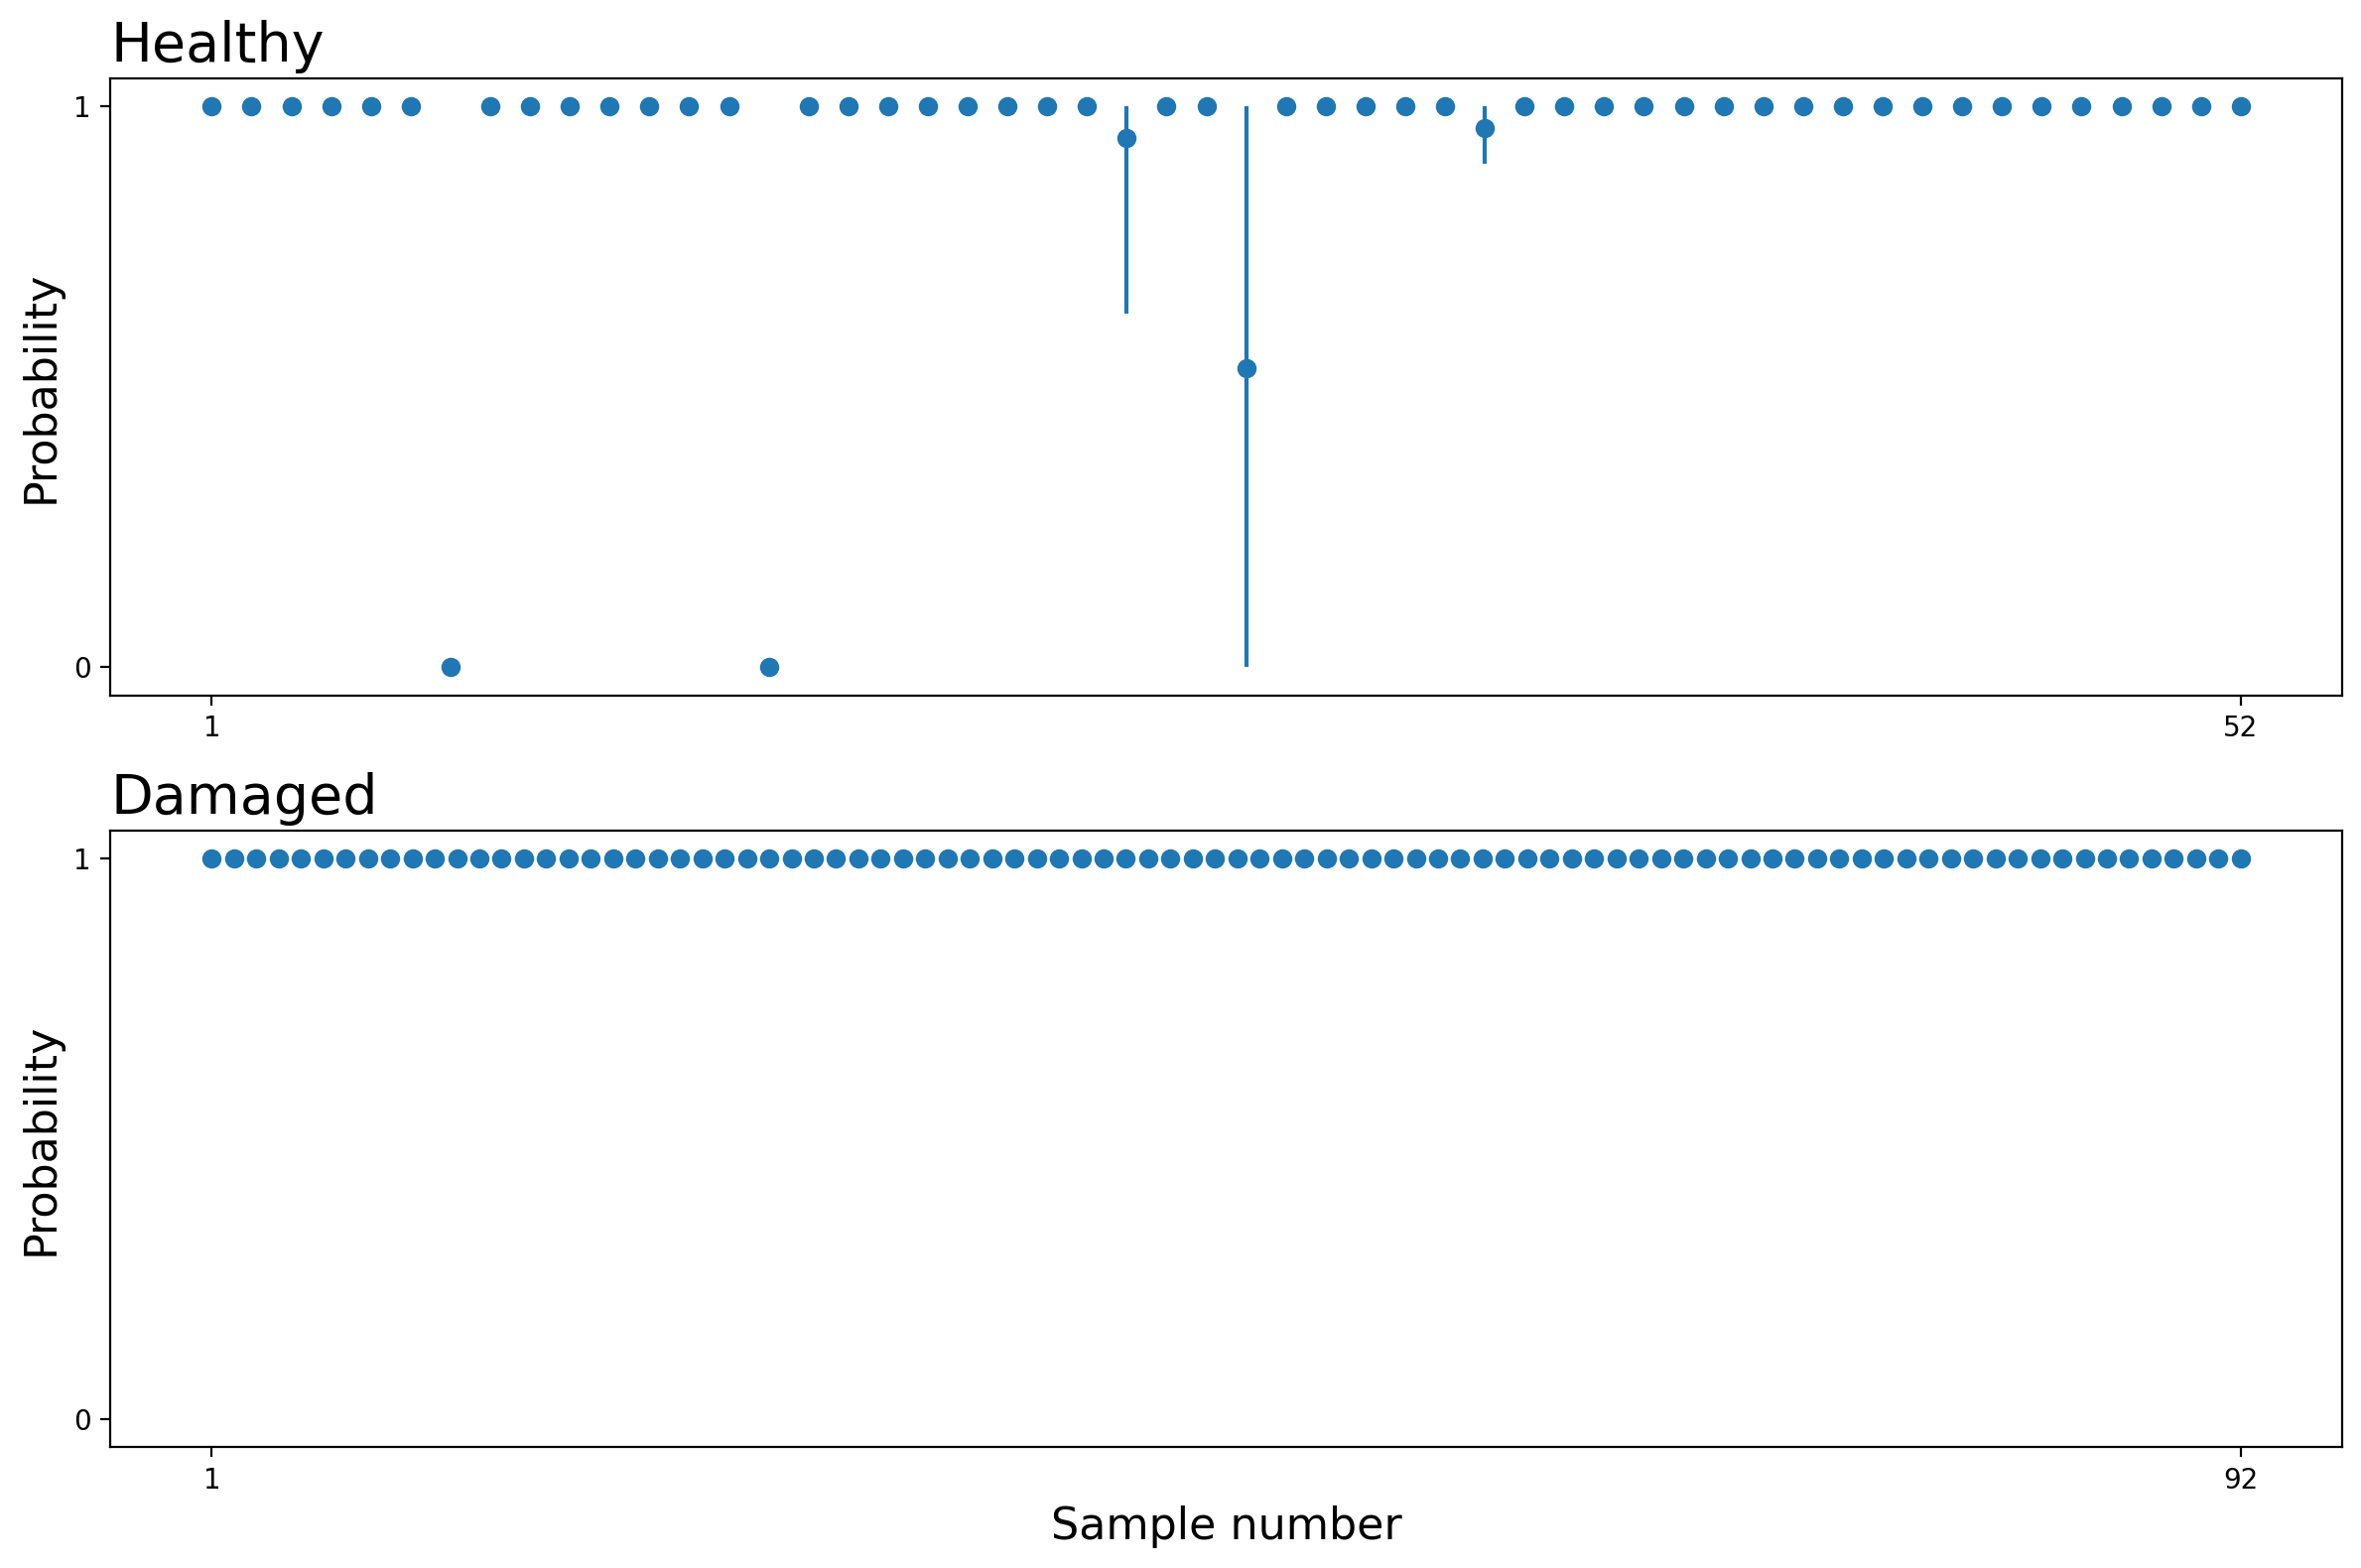

In [217]:
num_knots = 15
frequencies = gyro_agg_15['Frequencies']
data, labels, IT, IL, total,B0,knot_list,N = prepare_data(acc,frequencies=None,training_samples=[7,7], 
                                                        num_knots=num_knots, mode = 'binary')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
samples = get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary',plot=True,N=N)

19:44:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:44:40 - cmdstanpy - INFO - CmdStan done processing.


19:44:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:44:42 - cmdstanpy - INFO - CmdStan done processing.


19:44:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:44:45 - cmdstanpy - INFO - CmdStan done processing.


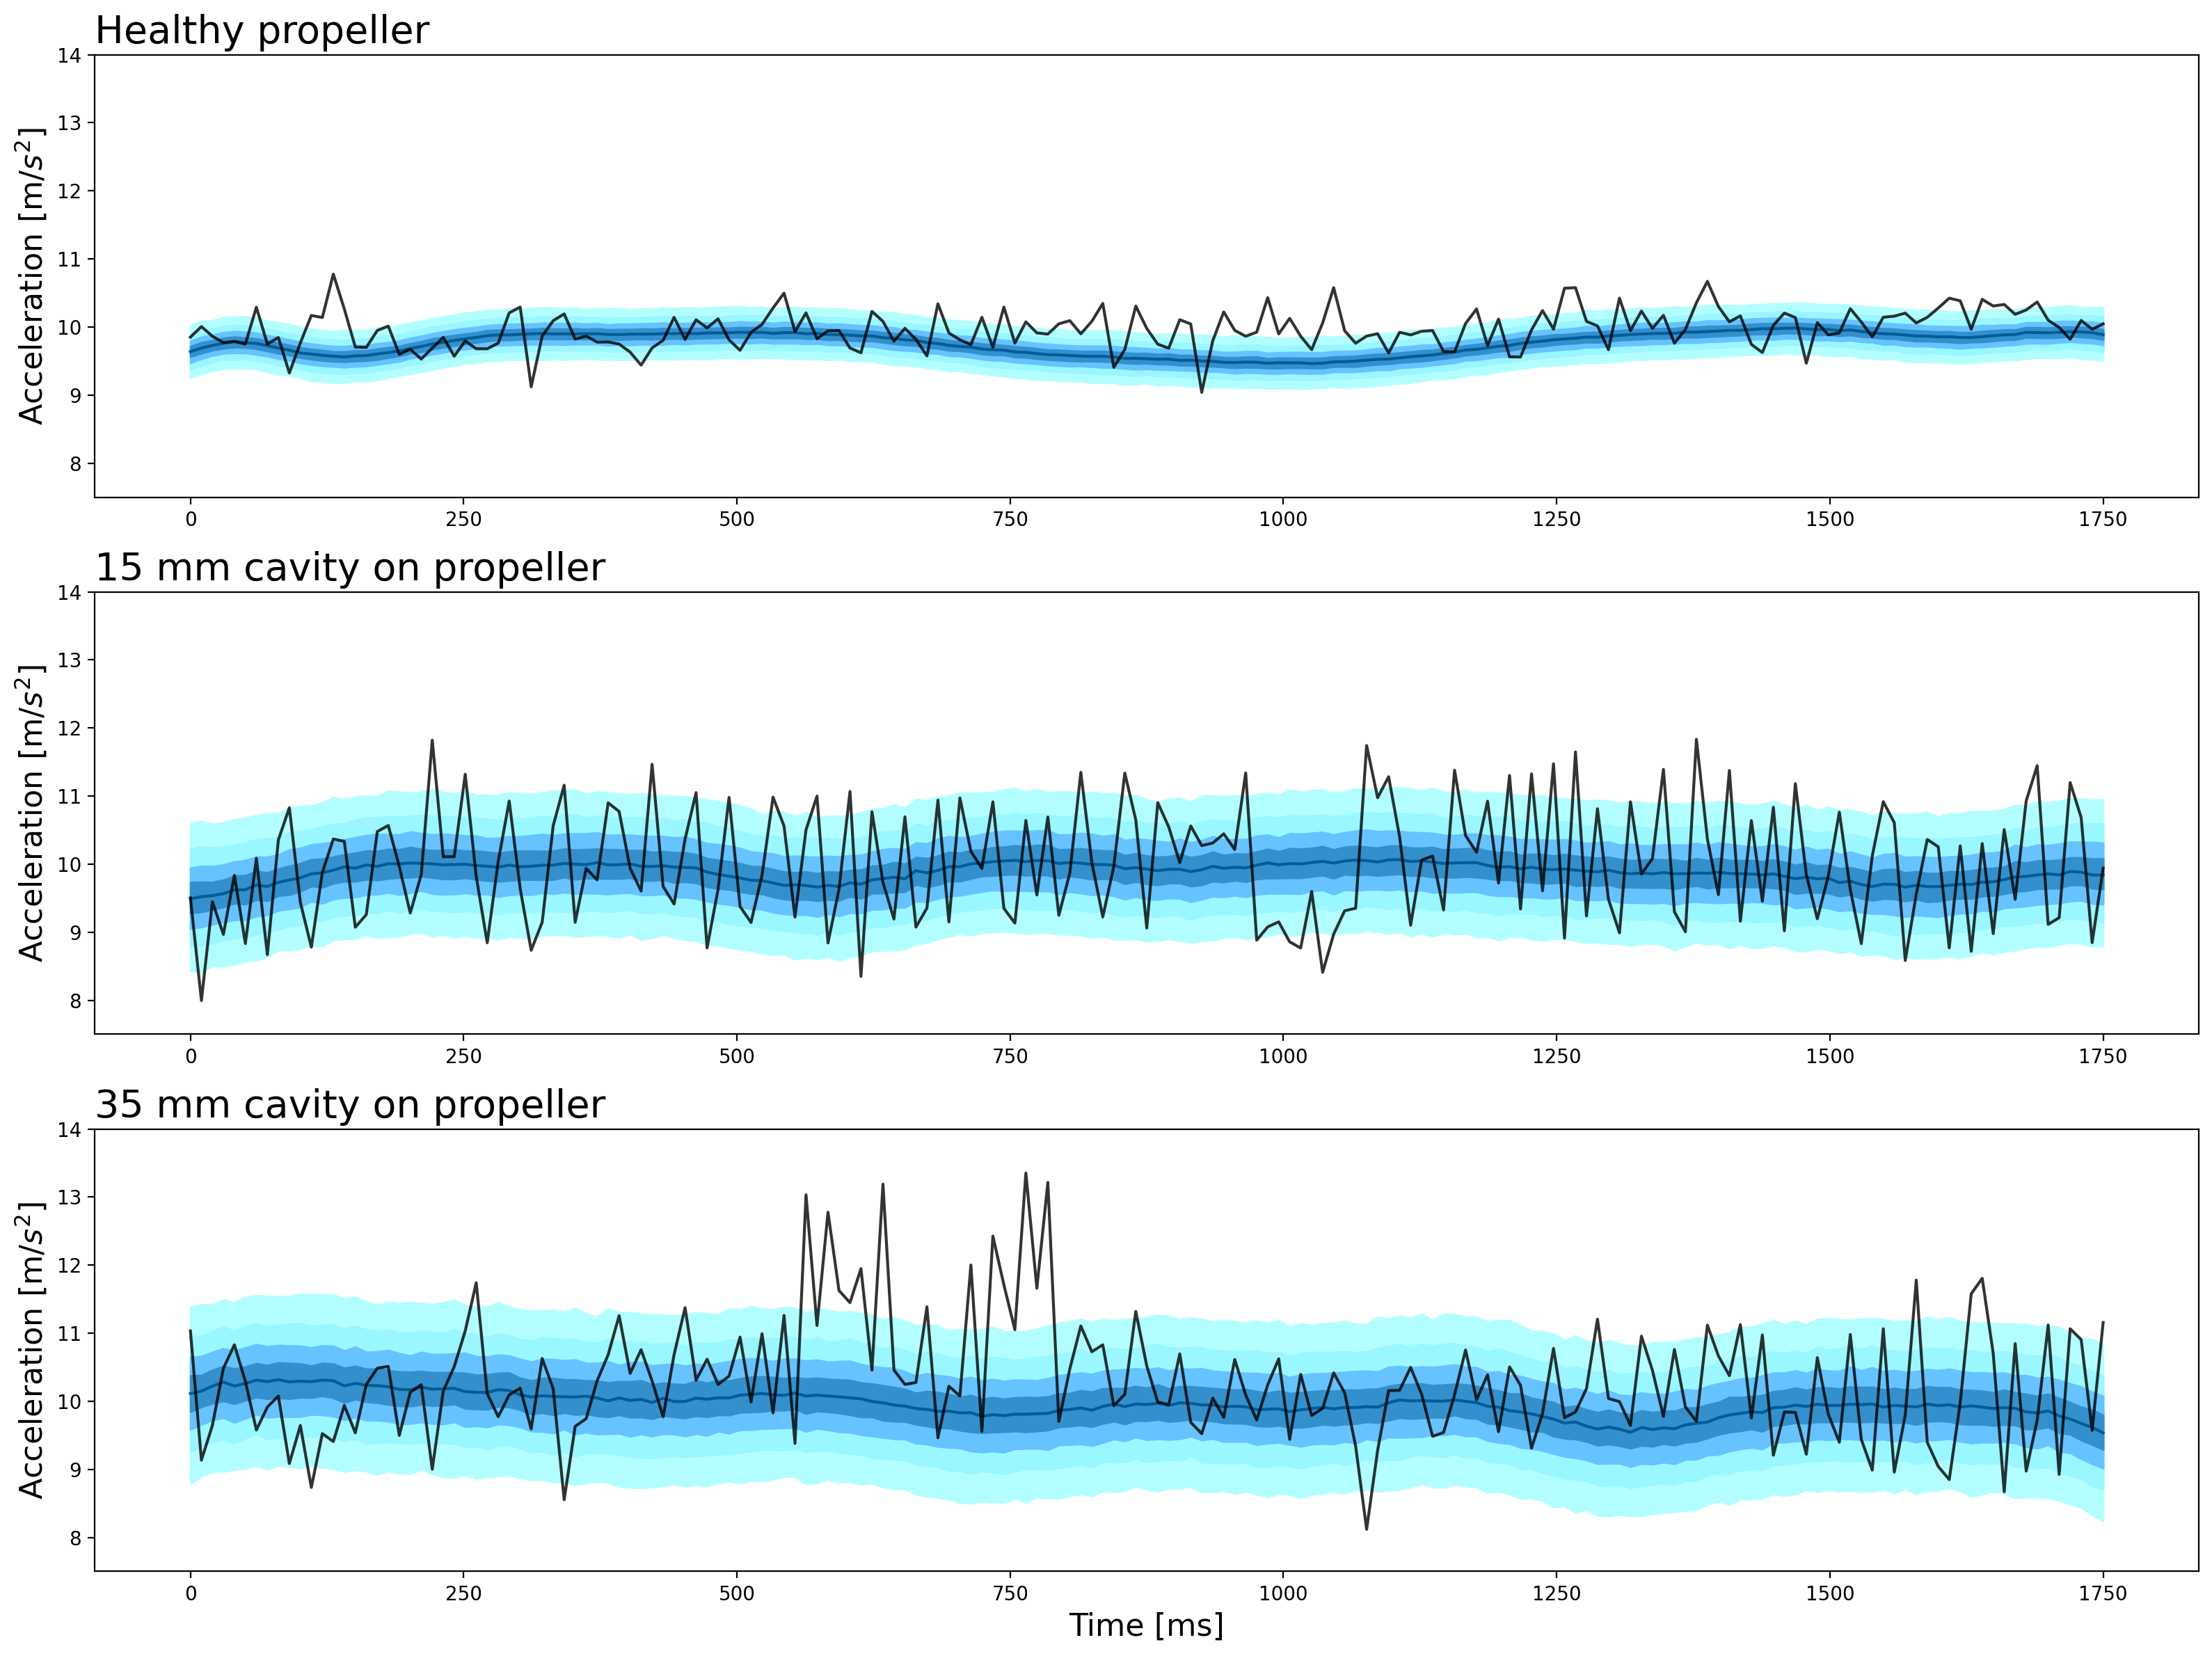

In [186]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 15
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior1 = model_posterior.sample(data=data_ppc)
fig,axes = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

x = np.linspace(0,1750,175)
y_pred1= samples_posterior1.stan_variable('y_hat')[:,:]
axes[0] = ribbon_plot(x,y_pred1,axes[0],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[0].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[0].set_title('Healthy propeller', loc= 'left',fontsize = 20)
axes[0].plot(x,acc_healthy_data[32], color = 'k',alpha=0.8)

model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[1]))])
y = acc[1][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior2 = model_posterior.sample(data=data_ppc)

y_pred2= samples_posterior2.stan_variable('y_hat')[:,:]
axes[1] = ribbon_plot(x,y_pred2,axes[1],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[1].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[1].set_title('15 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[1].plot(x,acc_15_data[10], color = 'k',alpha=0.8)



model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 8
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[2]))])
y = acc[2][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior3 = model_posterior.sample(data=data_ppc)

y_pred3= samples_posterior3.stan_variable('y_hat')[:,:]
axes[2] = ribbon_plot(x,y_pred3,axes[2],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[2].set_ylabel('Acceleration [m/$s^2$]',fontsize = 16)
axes[2].set_title('35 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[2].plot(x,acc_35_data[10], color = 'k',alpha=0.8)
axes[2].set_xlabel('Time [ms]',fontsize = 16)


axes[0].set_ylim(7.5,14)
axes[1].set_ylim(7.5,14)
axes[2].set_ylim(7.5,14)

fig.savefig('plots/gen_acc.jpg')

In [120]:
num_knots = 18
data, labels, IT, IL, total,B0,knot_list,n = prepare_data(acc,frequencies=None,training_samples=[7,5,7], 
                                                        num_knots=num_knots, mode = 'all')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
res,indicies = get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,mode='all',plot=True)

20:41:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:32 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.6762589928057554


In [121]:
probs = res.stan_variable('probabilities')
az.summary(res, var_names=[
    'probabilities'])

/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,1]",1.000,0.016,1.000,1.000,0.000,0.000,3510.0,3539.0,1.0
"probabilities[0,2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,3]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,4]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
"probabilities[2,134]",0.985,0.091,0.983,1.000,0.001,0.001,4221.0,3622.0,1.0
"probabilities[2,135]",0.172,0.314,0.000,0.957,0.005,0.004,4770.0,3643.0,1.0
"probabilities[2,136]",1.000,0.000,1.000,1.000,0.000,0.000,4016.0,4000.0,1.0
"probabilities[2,137]",1.000,0.001,1.000,1.000,0.000,0.000,3660.0,3747.0,1.0


In [122]:
az.summary(res, var_names=[
    'probabilities'])

/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,1]",1.000,0.016,1.000,1.000,0.000,0.000,3510.0,3539.0,1.0
"probabilities[0,2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,3]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,4]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
"probabilities[2,134]",0.985,0.091,0.983,1.000,0.001,0.001,4221.0,3622.0,1.0
"probabilities[2,135]",0.172,0.314,0.000,0.957,0.005,0.004,4770.0,3643.0,1.0
"probabilities[2,136]",1.000,0.000,1.000,1.000,0.000,0.000,4016.0,4000.0,1.0
"probabilities[2,137]",1.000,0.001,1.000,1.000,0.000,0.000,3660.0,3747.0,1.0


In [220]:
x = [probs[:,0,0],probs[:,0,135]]
y = [probs[:,1,0],probs[:,1,135]]
z = [probs[:,2,0],probs[:,2,135]]

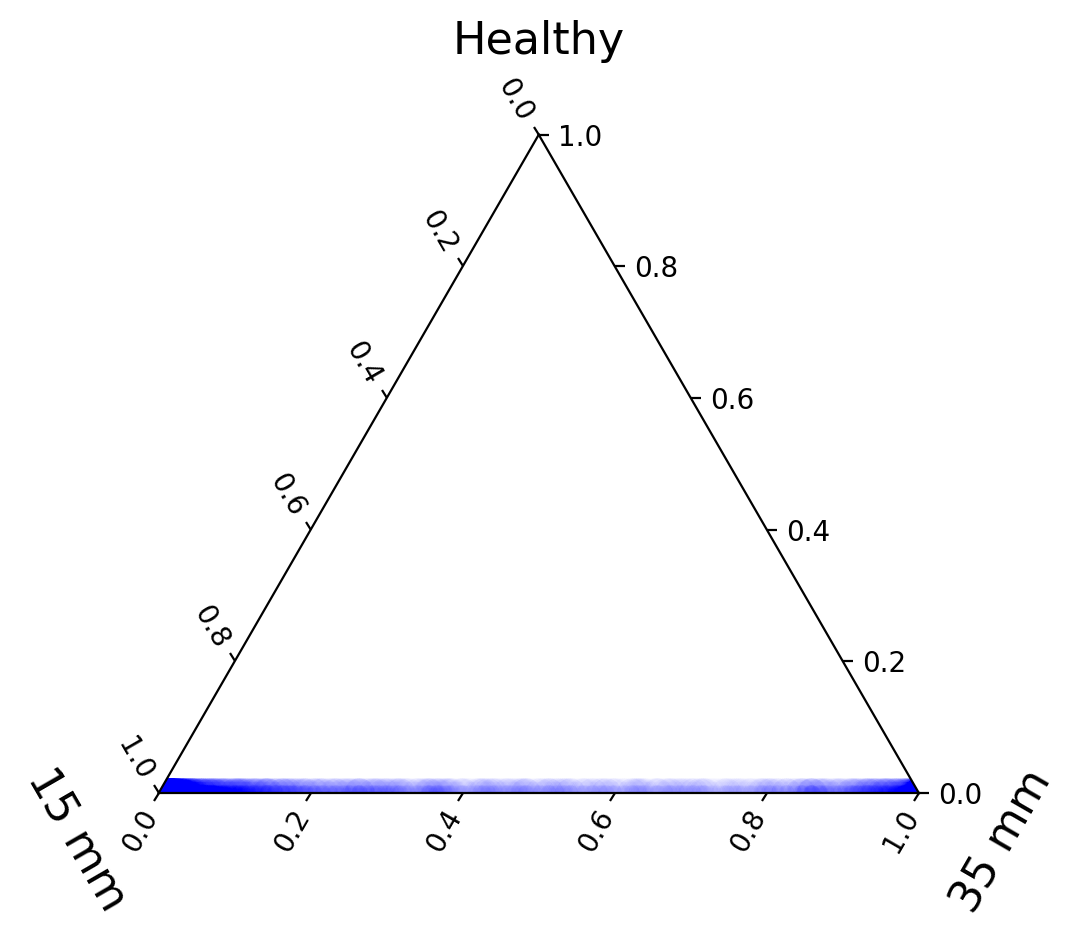

In [245]:
import mpltern 

fig = plt.figure(tight_layout=True)
fig.subplots_adjust(wspace=0.3)

positions = ['tick1']
for i, position in enumerate(positions):
    ax = fig.add_subplot(1, 1, i + 1, projection='ternary')

    ax.set_tlabel('Healthy', fontsize=16)
    ax.set_llabel('15 mm', fontsize=16)
    ax.set_rlabel('35 mm', fontsize=16)
    ax.scatter(x[1], y[1], z[1], c = 'blue',alpha = 0.01,linewidths=5)
    ax.set_title(f"", pad=42)

plt.show()
fig.savefig('plots/three_bad.jpg')

/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


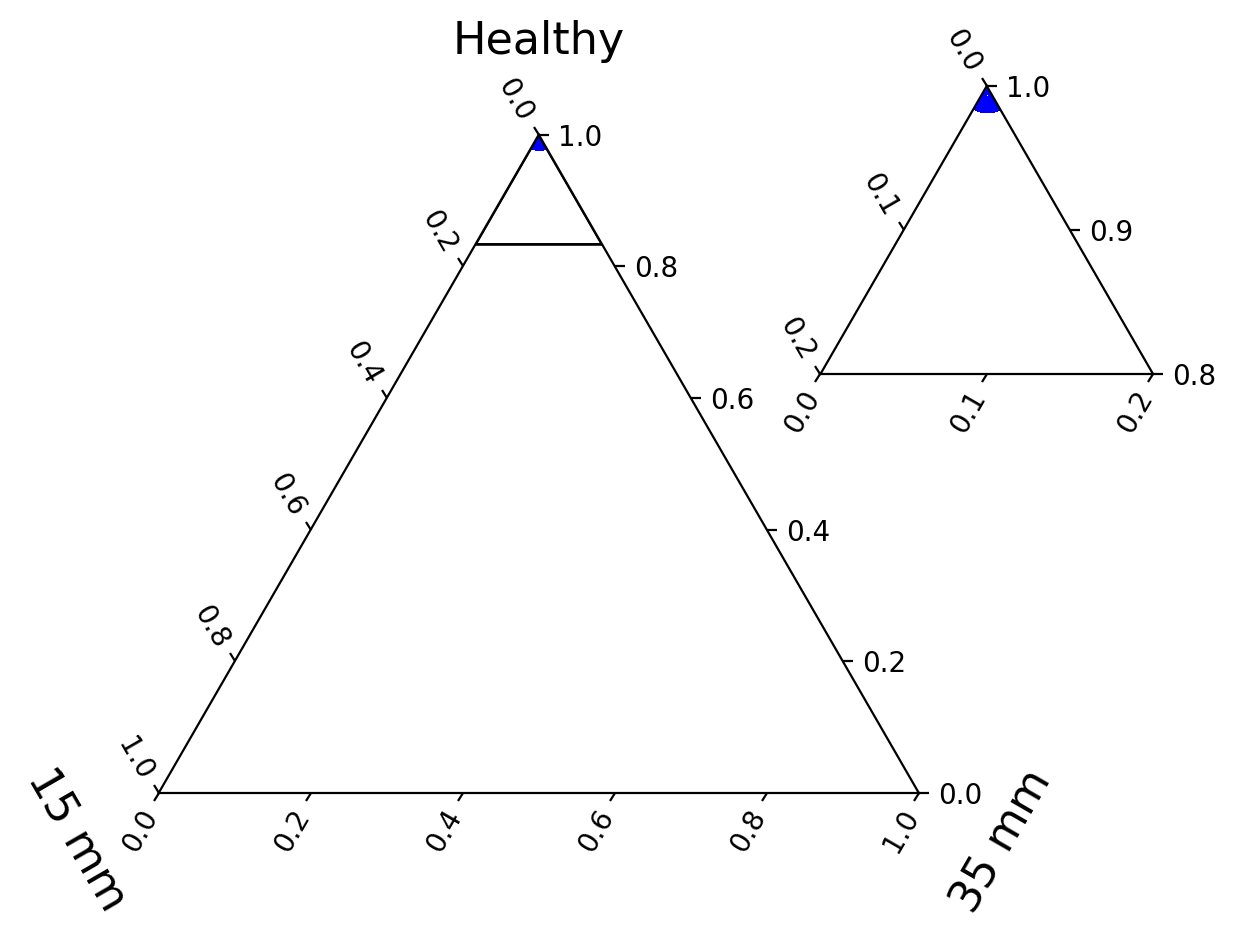

In [246]:
fig = plt.figure(tight_layout=True)
fig.subplots_adjust(left=-0.1)

ax = fig.add_subplot(projection="ternary")

ax.scatter(x[0], y[0], z[0], c = 'blue',alpha = 0.1,linewidths=5)

# Plot the triangle region for the inset.
ax.fill([1, 1, 1],[0,0.2, 0], [ 0, 0,0.2],  fc="none", ec="k")
ax.set_tlabel('Healthy', fontsize=16)
ax.set_rlabel('35 mm', fontsize=16)
ax.set_llabel('15 mm', fontsize=16)
# Create a new `TernaryAxes` for the inset with specifying a rectangle in the
# figure coordinates.
axins = fig.add_axes([0.7, 0.6, 0.30, 0.30], projection="ternary")

# Limit the ploting range to be consistent with the above plotted triangle.
axins.set_ternary_min(0.8, 0, 0)
axins.set_ternary_max(1, 0.2, 0.2)

axins.scatter(x[0], y[0], z[0], c = 'blue', linewidths=13)

plt.show()
fig.savefig('plots/3class_good.jpg')

### Diffrences between models
Three binary models for detecting drone propeller damage have been developed. The models differ primarily in terms of input data, which can be distinguished as follows:

    accelerometer with data aggregation in the time domain,
    gyroscope without data aggregation in the frequency domain,
    gyroscope with data aggregation in the frequency domain.

These models were developed due to the possibility of their direct application in unmanned aerial vehicles. The model using an accelerometer will require less computational power during integration, due to the limited number of operations performed. Meanwhile, the model based on a gyroscope must process input data after a Fourier transform, which increases computational complexity.

In [20]:
knots = [13,18,22]
frequencies = gyro_damaged['Frequencies']
num_iters = 100
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list = prepare_data(acc, frequencies=None, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary'))
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('res_new/agg_results.csv')

model = CmdStanModel(stan_file='stan/mix.stan')

# gyroscope without data aggregation in the frequency domain
result_dict_gyro = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro,index=[0])
    pd_res.to_csv('res_new/gyro_results.csv')

# gyroscope with data aggregation in the frequency domain
result_dict_gyro_agg = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro_agg, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
    pd_res.to_csv('res_new/gyro_agg_results.csv')

09:45:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

KeyboardInterrupt: 

In [ ]:
result_dict_gyro_agg

NameError: name 'result_dict_gyro_agg' is not defined